<a href="https://colab.research.google.com/github/fericazatti/CUDA_GPU_INTRODUCTION/blob/main/ICNPG_Desaf%C3%ADo_Langevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paul Langevin



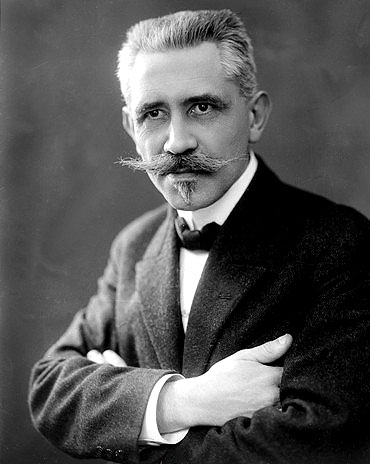

Paul Langevin (1872-1946) fue un físico francés destacado por su trabajo en varias áreas de la física, incluyendo la teoría del magnetismo, la teoría cinética de los gases, y la física estadística. Es también conocido por su desarrollo de la ecuación de Langevin, que describe el movimiento de partículas en un fluido, y por su contribución al efecto magneto-óptico. Langevin fue una de las figuras más influyentes en la física en el siglo XX, y su trabajo sigue siendo relevante en áreas como la física de partículas, el magnetismo y la teoría de sistemas complejos.

**Chisme**: Langevin tuvo una relación cercana con los Curie (Marie y Pierre Curie), dos de los científicos más importantes de su tiempo. Trabajó en el laboratorio de Pierre Curie y fue muy influenciado por las ideas de los Curie sobre la radiactividad. Además, su relación personal con Marie Curie fue bastante controvertida: Langevin y Marie Curie tuvieron un romance que causó mucho escándalo en la sociedad francesa de la época, especialmente debido a la notoriedad de Marie por su trabajo con Pierre Curie y la trágica muerte de este último en un accidente de tráfico.


# Resolver $N$ ecuaciones diferenciales estocásticas

Una partícula browniana moviéndose en solo una dimensión y atada a un resorte puede ser descripta por una ecuación de Langevin del tipo

$$\dot{x}(t)=-\kappa x(t) + \eta(t),$$

donde $x(t)$ es la posición de la partícula a tiempo $t$, y $\eta(t)$ un ruido gausiano descorrelacionado que imita la acción de un baño térmico, tal que $\langle \eta(t) \rangle=0$, y $\langle \eta(t)\eta(t') \rangle=2T \delta(t-t')$. El mismo tipo de ecuación describe un circuito eléctrico $RC$ en presencia de fluctuaciones térmicas, o ruido de Johnson–Nyquist.

En la práctica el método más simple para resolver esta ecuación es el método de Euler estocástico, usando diferencias temporales finitas,

$$x_{n+1}=x_n - \Delta t \;\kappa \;x_n + \sqrt{2T \Delta t} \;r_n,$$

donde $r_n$ es un número aleatorio con distribución gausiana de media cero y varianza uno, descorrelacionado en el tiempo, es decir $\langle r_n \rangle=0$, $\langle r_n r_m\rangle=\delta_{nm}$.

* Escriba un kernel para simular un número grande $N$ de estas partículas con posiciones $x^{(i)}_n$ para $i=0,...,N-1$, en función del tiempo, con $x^{(i)}_{n=0}=0$, descriptas por la misma ecuación estocástica. Fundamental: Asegúrese, usando adecuadamente un buen generador de números aleatorios paralelo de que el ruido de cada partícula este descorrelaciado en tiempo y con el ruido de las demás partículas, es decir $\langle r^{(i)}_n r^{(j)}_m\rangle = \delta_{nm}\delta_{ij}$.

* Muestre que a tiempos largos, la probabilidad de encontrar una partícula en $x$ es $P(x) \propto \exp(-\kappa x^2/2T)$, (si, ¡la distribución de Boltzmann!). Para ello construya un histograma de las posiciones al final de la corrida.

* **Opcional**: Si las partículas estuvieran en un potencial acotado cualesquiera, $V(x)$, a tiempos largos $P(x) \propto e^{-V(x)/T}$. Es decir, que la mecánica estadística de equilibrio siempre funciona para esta dinámica, en el estado estacionario.

* **Opcional**: a tiempos intermedios se puede comprobar numéricamente que la $P(x,t)$ obtenida del histograma satisface la ecuación de Fokker-Planck $\partial_t P(x,t)=\partial_x [{\kappa} x P(x,t)]+T \partial_x^2 P(x,t)$. ¡Es trabajoso pero muy instructivo!


# Instrucciones

* El problema es vergonzosamente paralelizable porque las partículas brownianas no interactúan.

* Es necesario alocar memoria de device para guardar la posición unidimensional de las $N \gg 1$ partículas.

* Es necesario generar buenos números aleatorios, distintos y descorrlacionados para cada partícula y para cada tiempo, y hacer el paso de Euler con la fuerza que actúa sobre cada una.

* Es necesario calcular el histograma de posiciones de las $N \gg 1$ partículas, que ya vimos puede hacerse con un kernel usando atomicAdd o bien usando una rutina de una librería paralelizada.

* Podes resolverlo en CUDA C/C++/python.

Tiempo en CPU: 271.8262 s
Tiempo en GPU: 3.6671 s
Speed-up (GPU/CPU): 74.13x


<ipython-input-4-40aee0c327fc>:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_theoretical /= np.trapz(P_theoretical, x_theoretical)


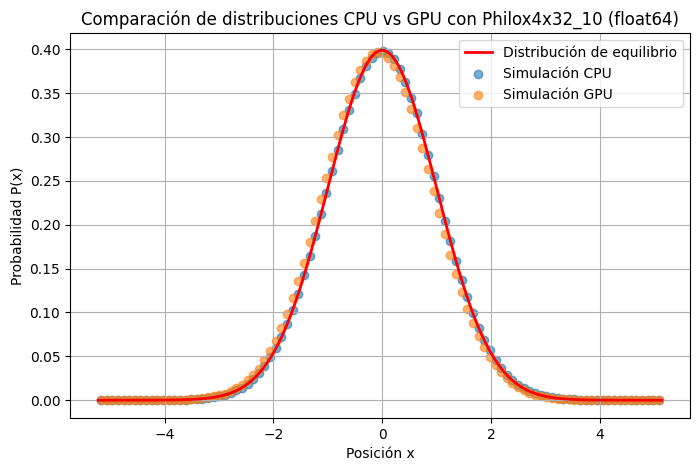

In [4]:


import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
from numpy.random import Generator, Philox

# Parámetros del sistema
N = 10000000      # Número de partículas
dt = 0.01         # Paso de tiempo
T = 1.0           # Temperatura
kappa = 1.0       # Constante del resorte
total_time = 10   # Tiempo total de simulación
num_steps = int(total_time / dt)  # Número de pasos de simulación

# ---- Kernel CUDA con float64 ----
philox_kernel = cp.RawKernel(r"""
#include <curand_kernel.h>

extern "C" __global__
void langevin_philox(double *x, int N, double dt, double kappa, double sqrt2Tdt, unsigned long long seed, int num_steps) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= N) return;

    curandStatePhilox4_32_10_t state;
    curand_init(seed, idx, 0, &state);

    for (int step = 0; step < num_steps; step++) {
        double noise = curand_normal_double(&state);  // Generar ruido con float64
        x[idx] = x[idx] - kappa * x[idx] * dt + sqrt2Tdt * noise;
    }
}
""", "langevin_philox")

# ---- GPU: Simulación con float64 ----
def simulate_gpu(N, num_steps, dt, kappa, T):
    x = cp.zeros(N, dtype=cp.float64)  # Asegurar float64 en GPU
    sqrt2Tdt = np.sqrt(2 * T * dt).astype(np.float64)
    threads_per_block = 256
    blocks_per_grid = (N + threads_per_block - 1) // threads_per_block
    seed = int(time.time())

    start_time = time.time()
    philox_kernel((blocks_per_grid,), (threads_per_block,), (x, N, dt, kappa, sqrt2Tdt, seed, num_steps))

    cp.cuda.Device(0).synchronize()
    end_time = time.time()
    return cp.asnumpy(x), end_time - start_time

# ---- CPU: Simulación con float64 ----
def simulate_cpu(N, num_steps, dt, kappa, T):
    rng = Generator(Philox())
    x = np.zeros(N, dtype=np.float64)
    start_time = time.time()

    for _ in range(num_steps):
        eta = rng.standard_normal(N)
        x += -kappa * x * dt + np.sqrt(2 * T * dt) * eta

    end_time = time.time()
    return x, end_time - start_time

# Ejecutar simulaciones en CPU y GPU
x_cpu, time_cpu = simulate_cpu(N, num_steps, dt, kappa, T)
x_gpu, time_gpu = simulate_gpu(N, num_steps, dt, kappa, T)

# Calcular speed-up
speed_up = time_cpu / time_gpu

# Mostrar resultados
print(f"Tiempo en CPU: {time_cpu:.4f} s")
print(f"Tiempo en GPU: {time_gpu:.4f} s")
print(f"Speed-up (GPU/CPU): {speed_up:.2f}x")

# ---- Histograma de posiciones ----
plt.figure(figsize=(8,5))
hist_cpu, bins = np.histogram(x_cpu, bins=100, density=True)
hist_gpu, _ = np.histogram(x_gpu, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Distribución teórica
x_theoretical = np.linspace(min(x_cpu), max(x_cpu), 200)
P_theoretical = np.exp(-kappa * x_theoretical**2 / (2 * T))
P_theoretical /= np.trapz(P_theoretical, x_theoretical)

plt.plot(x_theoretical, P_theoretical, 'r-', linewidth=2, label="Distribución de equilibrio")
plt.scatter(bin_centers, hist_cpu, label="Simulación CPU", alpha=0.6)
plt.scatter(bin_centers, hist_gpu, label="Simulación GPU", alpha=0.6)
plt.xlabel("Posición x")
plt.ylabel("Probabilidad P(x)")
plt.title("Comparación de distribuciones CPU vs GPU con Philox4x32_10 (float64)")
plt.legend()
plt.grid(True)
plt.show()